<a href="https://colab.research.google.com/github/alfinmaulani/skripsi/blob/master/combined(glove).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade scikit-learn
import numpy as np
import pandas as pd
import io
import os
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
import gensim

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
url0='https://raw.githubusercontent.com/alfinmaulani/skripsi/master/dataISEAR.csv'
df = pd.read_csv(url0)
df=df.drop(df[df['emosi'] == 'shame'].sample(frac=1).index)
df=df.drop(df[df['emosi'] == 'guilt'].sample(frac=1).index)

In [ ]:
df.emosi.value_counts()

joy        1092
sadness    1082
anger      1079
fear       1076
disgust    1066
Name: emosi, dtype: int64

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dfgab=pd.read_csv('/content/drive/MyDrive/korpusblognewstweet.csv')

In [ ]:
dfblog = pd.read_csv('/content/drive/MyDrive/korpusblogspertiga.csv')

In [ ]:
dftwit = pd.read_csv('/content/drive/MyDrive/twitter_prosessed.csv')

In [ ]:
dftwit2 = pd.read_csv('/content/drive/MyDrive/cstwitter_prosessed.csv')

In [ ]:
df1 = pd.read_csv(url0)
df1=df1.drop(df1[df1['emosi'] == 'joy'].sample(frac=1).index)
df1=df1.drop(df1[df1['emosi'] == 'sadness'].sample(frac=1).index)
df1=df1.drop(df1[df1['emosi'] == 'anger'].sample(frac=1).index)
df1=df1.drop(df1[df1['emosi'] == 'fear'].sample(frac=1).index)
df1=df1.drop(df1[df1['emosi'] == 'disgust'].sample(frac=1).index)

In [ ]:
df2=pd.read_csv('https://raw.githubusercontent.com/alfinmaulani/skripsi/master/korpus2.txt', delimiter = ";")
df2.columns=['dok','tes']

In [ ]:
df3=pd.read_csv('https://raw.githubusercontent.com/alfinmaulani/skripsi/master/korpus3.csv')

In [ ]:
df4=pd.read_csv('https://raw.githubusercontent.com/alfinmaulani/skripsi/master/korpus4.tsv', delimiter = "	")
df4.columns=['dok','num','code']

In [ ]:
df5=pd.read_csv('https://raw.githubusercontent.com/alfinmaulani/skripsi/master/twitter_prosessed2.csv')#bad

In [ ]:
# df3 = pd.read_csv('/content/drive/MyDrive/idwiki_new_lower.txt', delimiter = "\t")
# df3.columns = ["arti"]

In [ ]:
# df4 = pd.read_csv('/content/drive/MyDrive/idwiki_new_lower2.txt', delimiter = "\t")
# df4.columns = ["arti"]

persiapan corpus tambahan

In [4]:
final=[]

In [5]:
final.extend(dfgab.teks)

In [ ]:
final.extend(dfblog.teks)

In [ ]:
final.extend(dftwit.tweet)

In [ ]:
final.extend(dftwit2.teks)

In [ ]:
final.extend(df1.dokumen)

In [ ]:
final.extend(df2.dok)

In [ ]:
final.extend(df3.content)

In [ ]:
final.extend(df4.dok)

In [ ]:
final.extend(df5.content)

In [6]:
dfg = pd.DataFrame(final)
dfg.columns=["dok"]

preputama : lower case

In [7]:
def lower(temp):
  return temp.str.lower()

In [8]:
df['dokumen']=lower(df['dokumen'])

In [9]:
dfg['dok']=lower(dfg['dok'])

preputama : Pembersihan noise (over enter and space)

In [10]:
def bersih_noise(temp):
  temp=temp.replace(' \n', ' ', regex=True)
  temp=temp.replace('   ', ' ', regex=True)
  return temp.replace('  ', ' ', regex=True)

In [11]:
df=bersih_noise(df)

In [12]:
dfg=bersih_noise(dfg)

preptambah : expand contractions

In [13]:
!pip install contractions
import contractions
def expand_word(temp):
  expanded_words = []   
  for word in temp:
    expanded_words.append(contractions.fix(word))
  return expanded_words

     |████████████████████████████████| 284 kB 3.9 MB/s 
     |████████████████████████████████| 321 kB 31.2 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85450 sha256=5cc90011fc2437ee8c4138c3db7309bf9ae3701a4b8f170dec6fe68c8126e0c0
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick


In [14]:
df.dokumen=expand_word(df.dokumen)

In [15]:
dfg.dok=expand_word(dfg.dok)

preputama : cleansing punctuation

In [16]:
def clns_punc(temp):
  return temp.str.replace(r'[^\w\s]+', '')

In [17]:
df['dokumen'] = clns_punc(df['dokumen'])

In [18]:
dfg['dok'] = clns_punc(dfg['dok'])

preputama : cleansing number

In [19]:
!pip install tweet-preprocessor
import preprocessor as p
p.set_options(p.OPT.NUMBER)
def clns_numb(temp):
  sementara=[]
  for word in temp:
    sementara.append(p.clean(word))
  return sementara

In [20]:
df.dokumen=clns_numb(df.dokumen)

In [21]:
dfg.dok=clns_numb(dfg.dok)

preptambah : remove stopword

In [22]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words('english')
pat = r'\b(?:{})\b'.format('|'.join(stop))
def remove_stopw(temp):
  temp=temp.str.replace(pat, '')
  return temp.str.replace(r'\s+', ' ')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [23]:
df['dokumen'] = remove_stopw(df['dokumen'])

In [24]:
dfg['dok'] = remove_stopw(dfg['dok'])

tokenizing

In [25]:
def token(temp):
  return [word_tokenize(x) for x in temp]

In [26]:
df.dokumen=token(df.dokumen)

In [27]:
dfg.dok=token(dfg.dok)

preptambah : Lemmatization

In [28]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
def lemma(temp):
  temp.apply(lambda x: [stemmer.stem(y) for y in x])

In [29]:
lemma(df['dokumen'])

In [30]:
lemma(dfg['dok'])

save df

In [ ]:
# df.to_csv(r'dataisear(preptambah).csv', index = False)

gabung corpus

In [ ]:
# sent=df.dokumen

In [31]:
sent=dfg.dok.append(df.dokumen,ignore_index=True)

glove

In [32]:
!pip install glove-python-binary
from glove import Glove
from glove import Corpus

In [33]:
korpus = Corpus()
korpus.fit(sent, window=5, ignore_missing=True)
glove = Glove(no_components=100, learning_rate=0.1, alpha=0.025, max_loss=100.0)
glove.fit(korpus.matrix)
glove.add_dictionary(korpus.dictionary)

cek model

In [34]:
glove.word_vectors.shape

(894286, 100)

In [ ]:
glove.word_vectors[glove.dictionary['moment']]

ekstraksi fitur

In [35]:
import array
ekstrak=[]
temp=array.array('i',(0,)*100)
for senten in df.dokumen:
  for word in senten:
    temp=np.add(temp,glove.word_vectors[glove.dictionary[word]])
  temp=temp/len(senten)
  ekstrak.append(temp)
has_vec=ekstrak

In [36]:
X=has_vec
y=df.emosi
print(np.shape(X))
print(np.shape(y))
# print(X)
# print(y)

(5395, 100)
(5395,)


klasifikasi svm

In [37]:
from sklearn import svm
from sklearn.model_selection import cross_val_score

In [ ]:
# langsung cari score

# clf = svm.SVC(kernel='poly', decision_function_shape='ovr')
# scores = cross_val_score(clf, X, y, cv=10)
# # scores.mean()

conf matrix dan akurasi

In [38]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
# svm.SVC(C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, 
#  class_weight=None, verbose=False, max_iter=- 1, decision_function_shape='ovr', break_ties=False, random_state=None)

In [ ]:
# cross_val_predict(estimator, X, y=None, *, groups=None, cv=None, n_jobs=None, verbose=0, fit_params=None, 
# pre_dispatch='2*n_jobs', method='predict')

In [39]:
def klasifikasi(krnl):
  clf = svm.SVC(kernel=krnl, decision_function_shape='ovr')
  y_pred = cross_val_predict(clf, X, y, cv=10)
  ConfusionMatrixDisplay.from_predictions(y, y_pred)
  plt.show()
  print(accuracy_score(y, y_pred))
  print(precision_recall_fscore_support(y, y_pred, average='macro'))

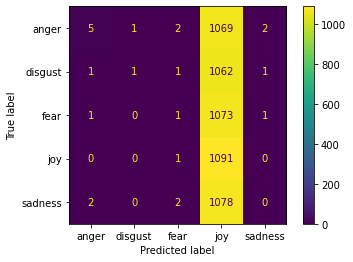

0.20352177942539387
(0.28029299938847674, 0.20111712474289994, 0.07008404503100177, None)


In [40]:
klasifikasi('poly')

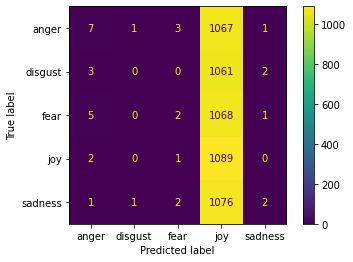

0.20389249304911955
(0.235071193185351, 0.2014894801125832, 0.07152920392719442, None)


In [41]:
klasifikasi('rbf')

In [ ]:
klasifikasi('linear')